# 下载并加载数据

In [804]:
import zipfile
import pandas as pd
#download and unzip data from kaggle
zip_path = './house-prices-advanced-regression-techniques.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('./data/')

train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')
print(train_data.shape)
print(test_data.shape)


(1460, 81)
(1459, 80)


# 处理数据

In [805]:
import torch
all_features = pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:]))
print(all_features.shape)

numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
all_features[numeric_features] = all_features[numeric_features].fillna(0)

all_features = pd.get_dummies(all_features, dummy_na=True)


num_train_data = train_data.shape[0]
train_features = torch.tensor(all_features[:num_train_data].values, dtype=torch.float32)
test_features = torch.tensor(all_features[num_train_data:].values, dtype=torch.float32)
print(train_features.shape)
print(test_features.shape)
# train_labels = torch.tensor(train_data.iloc[:,-1].values,dtype=torch.float32)
train_labels = torch.tensor(train_data['SalePrice'].values.reshape(-1,1),dtype=torch.float32)
print(train_labels.shape)




(2919, 79)
torch.Size([1460, 331])
torch.Size([1459, 331])
torch.Size([1460, 1])


# 训练数据

### 1. 构建迭代器

In [806]:
from torch.utils import data
batch_size = 256
dataset = data.TensorDataset(train_features, train_labels)
data_iter = data.DataLoader(dataset,batch_size,shuffle=True)
for X,y in data_iter:
    print(f'X:{X.shape}\ny:{y.shape}')
    break


X:torch.Size([256, 331])
y:torch.Size([256, 1])


### 2.构建网络

In [807]:
from torch import nn
from d2l import torch as d2l
num_inputs = 331
num_hiddens1 = 256
num_hiddens2 = 128
num_outputs = 1

def get_net():
  net = nn.Sequential(
  nn.Linear(num_inputs, num_hiddens1),
  nn.ReLU(),
  nn.Dropout(0.2),
  nn.Linear(num_hiddens1, num_hiddens2),
  nn.ReLU(),
  nn.Dropout(0.2),
  nn.Linear(num_hiddens2, 1),
  )
  return net
loss = nn.MSELoss()

### 3.训练

In [808]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    dataset = data.TensorDataset(train_features, train_labels)
    train_iter= data.DataLoader(dataset,batch_size,shuffle=True)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse:{float(train_ls[-1]):f}, '
              f'验证log rmse:{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

折1，训练log rmse:0.154748, 验证log rmse:0.197640
折2，训练log rmse:0.117666, 验证log rmse:0.177232
折3，训练log rmse:0.099401, 验证log rmse:0.167580
折4，训练log rmse:0.115188, 验证log rmse:0.149518
折5，训练log rmse:0.104197, 验证log rmse:0.173002
5-折验证: 平均训练log rmse: 0.118240, 平均验证log rmse: 0.172994


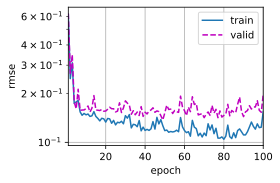

In [809]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.07, 10, 128
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

In [810]:
import numpy as np
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

训练log rmse：0.110807


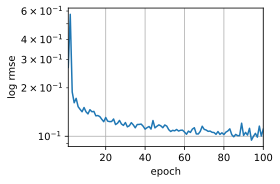

In [811]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)      